In [50]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave


In [51]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 64
resolution = (64, 64)

# These many images will be used from the data archive
dataset_split = 10000

photos_path = './imagenet/all_kinds'
# photos_path = './imagenet/pomegranate/train'

train_split = 0.8
random_seed = 42


photos = []
for photo_name in os.listdir(photos_path):
    photo = load_img(os.path.join(photos_path, photo_name))
    photo = photo.resize(resolution)
    photo_array = img_to_array(photo)
    photos.append(photo_array)

photos_np = np.array(photos, dtype=float)
photos_np /= 255.0

LAB_images = rgb2lab(photos_np)
X = LAB_images[:, :, :, 0]
y = np.array(photos_np)


train_x, test_x, train_y, test_y = train_test_split(
    X, y, train_size=train_split, random_state=random_seed)

# train_x = train_x.reshape(train_x.shape[0], img_size, img_size, 1)
# test_x = test_x.reshape(test_x.shape[0], img_size, img_size, 1)


# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


In [52]:
train_x.shape

(8000, 64, 64)

In [53]:

def get_generator_model():

    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 1))

    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)(conv1)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1)(conv2)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)

    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(
        3, 3), strides=1, activation='relu', padding='same')(conv3)

    concat_1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(
        128, kernel_size=(3, 3), strides=1, activation='relu')(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(
        128, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(
        64, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3, conv2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(
        64, kernel_size=(3, 3), strides=1, activation='relu')(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(
        64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2, conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3, 3), strides=1, activation='relu')(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_1)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(
        3, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_1)

    model = tf.keras.models.Model(inputs, conv_up_1)
    print(model.summary())
    return model


In [54]:

def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) ,padding='same', strides=1 , activation='relu' , input_shape=( img_size, img_size , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    print(model.summary())
    return model


In [55]:

cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(
        real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1), real_output)
    fake_loss = cross_entropy(tf.zeros_like(
        fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output, real_y):
    real_y = tf.cast(real_y, 'float32')
    return mse(fake_output, real_y)


generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

generator = get_generator_model()
discriminator = get_discriminator_model()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 60, 60, 16)   416         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 60, 60, 16)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 58, 58, 32)   4640        leaky_re_lu_18[0][0]             
____________________________________________________________________________________________

In [56]:

@tf.function
def train_step(input_x, real_y):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # print(train_x.shape)
        # Generate an image -> G( x )
        generated_images = generator(input_x, training=True)
        # print('after generator 1')
        # Probability that the given image is real -> D( x )
        # print(f'real y shape {real_y.shape}')
        real_output = discriminator(real_y, training=True)
        # print('after discriminator 1')
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        # print('after discriminator 2')

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss(generated_images, real_y)
        # Log loss for the discriminator
        disc_loss = discriminator_loss(real_output, generated_output)
        # print('after loss')

    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))


In [57]:
!pip install tqdm
from tqdm import tqdm

In [58]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

# # Generate training data
# batch_size = 1
# def batch_generator(batch_size):
#     for photos_batch in datagen.flow(photos_np, batch_size=batch_size):
#         # scikit-image
#         LAB_images = rgb2lab(photos_batch)
#         X_batch = LAB_images[:, :, :, 0]
#         Y_batch = np.array(photos_batch)
#         yield (X_batch, Y_batch)


In [59]:
# len(datagen.flow(photos_np, batch_size=batch_size))

In [71]:
# epochs = 100
# for epoch in tqdm(range(epochs), desc="epochs", position=0):
#     for (x, y) in tqdm(batch_generator(batch_size), desc="steps", position = 1):
#         train_step(x, y)
#     print('done', epoch)
epochs = 100
# for epoch in tqdm(range(epochs), desc="epochs", position=0):
for epoch in range(epochs):
    for (x, y) in tqdm(dataset, desc=f"steps for epoch {epoch}"):
        train_step(x, y)
    # print('done', epoch)


steps for epoch 99: 100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


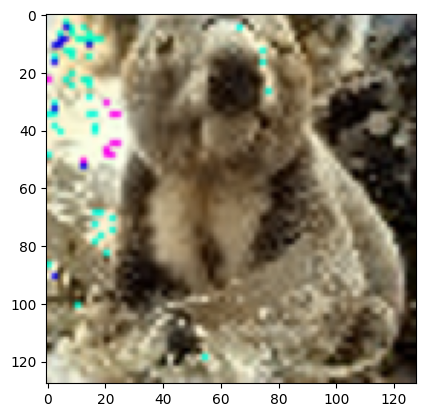

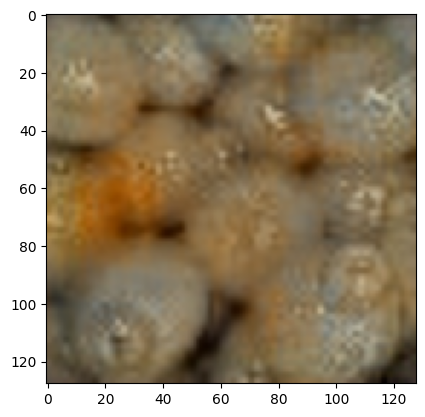

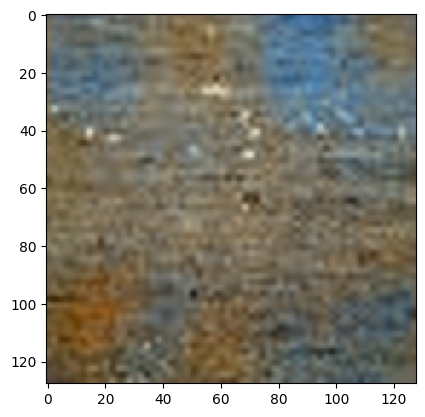

In [72]:
render_resolution = (128, 128)
import matplotlib.pyplot as plt
import random
y = generator(test_x[0: 25]).numpy()
samples = random.sample(range(25), 3 )
for i in samples:
    image = Image.fromarray((y[i] * 255).astype('uint8')).resize(render_resolution)
    image = np.asarray(image)
    plt.imshow(image)
    plt.show()


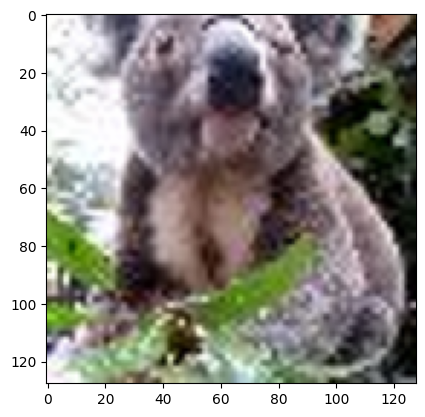

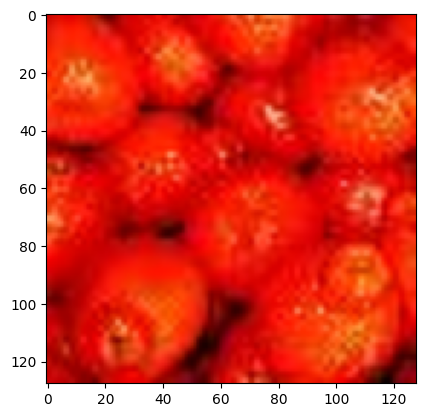

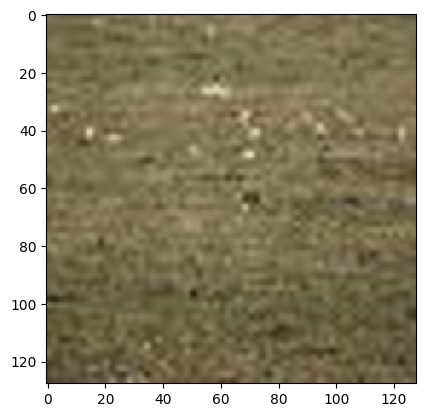

In [73]:
for i in samples:
    image = Image.fromarray((test_y[i] * 255).astype('uint8')).resize(render_resolution)
    plt.imshow(image)
    plt.show()


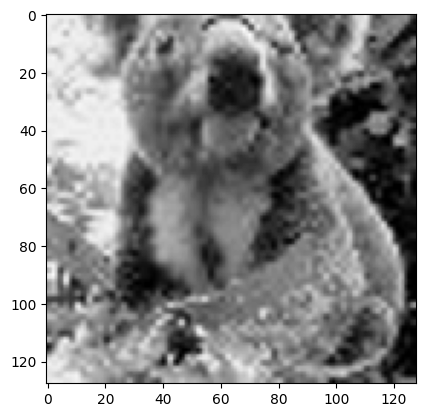

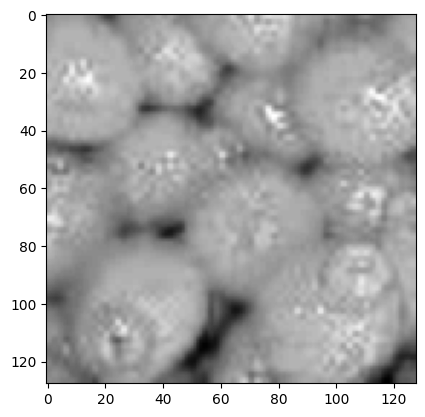

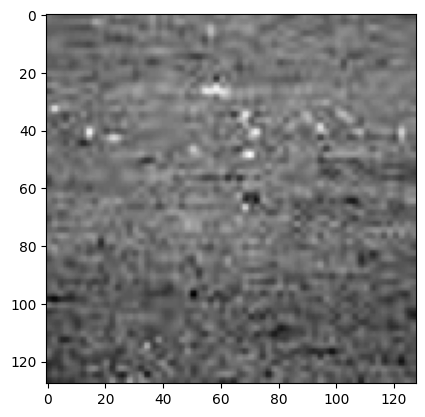

In [74]:

import matplotlib.pyplot as plt
for i in samples:
    image = Image.fromarray((test_x[i] ).astype('uint8')).resize(render_resolution)
    # plt.imshow(image)
    plt.imshow(np.array(image), cmap='gray')
    plt.show()
